<a href="https://colab.research.google.com/github/SahuUtkarsh03/AC102/blob/main/AC102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
 #installing RDkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
! conda install -c rdkit rdkit -y 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-07-16 12:05:33--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   140MB/s    in 0.6s    

2021-07-16 12:05:33 (140 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [4]:
#downloading dataset
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2021-07-16 12:07:48--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2021-07-16 12:07:48 (3.94 MB/s) - ‘delaney.csv’ saved [58889/58889]



#Importing Libraries

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


#custom function called generate() for computing the 3 descriptors LogP, MW and RB.

In [7]:
def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLog(Kow)","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [8]:
df = generate(sol.SMILES)
df

,MolLog(Kow),MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#a custom function called AromaticAtoms()

In [9]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

#Computing the aromatic proportion (AP) descriptor


In [27]:
desc_AromaticProportion = [AromaticAtoms(Chem.MolFromSmiles(element))/Descriptors.HeavyAtomCount(Chem.MolFromSmiles(element)) for element in sol.SMILES]

In [28]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion,columns =['Aromatic proportion'])
df_desc_AromaticProportion

,Aromatic proportion
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


#concating the two Data Frames calculated till now, also known as X matrix

In [29]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLog(Kow),MolWt,NumRotatableBonds,Aromatic proportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


#Y matrix creation

In [30]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2)

In [32]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#Linear Regression Model
###As the original study by Delaney and the investigation by Walters used linear regression for model building, therefore for comparability we will also be using linear regression as well.

In [33]:
Y_pred_train = model.predict(X_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.72799076 -0.00678421  0.01369207 -0.37552695]
Intercept: 0.22534297551820837
Mean squared error (MSE): 1.03
Coefficient of determination (R^2): 0.76


#Predict the LogS value of X_test data

In [26]:
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f' % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.72827793 -0.00683165 -0.00112886 -0.37325709]
Intercept: 0.3114022544878621
Mean squared error (MSE): 1.02
Coefficient of determination (R^2): 0.77


In [25]:
yintercept = '%.2f' % model.intercept_
LogKow = '%.2fLog(Kow)' % model.coef_[0]
MW = '%.4fMW' % model.coef_[1]
RB = '%.4fRB' % model.coef_[2]
AP = '%.2fAP' % model.coef_[3]
print('LogS = ' +' ' + yintercept + ' ' + LogKow + ' ' + MW + ' ' + RB + ' ' + AP)

LogS =  0.31 -0.73Log(Kow) -0.0068MW -0.0011RB -0.37AP


#Scatter plot of experimental vs. predicted LogS

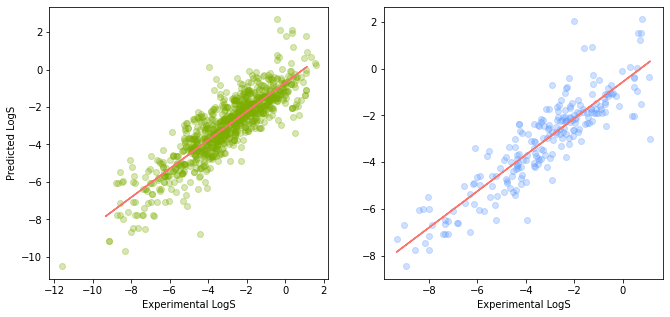

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.show()

#pickeling the model


In [ ]:
import pickle
filename = 'solubility_model.pkl'
pickle.dump(model, open(filename, 'wb'))